In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [20]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
# path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        print(experiment,min_file)
        min_exp[i] = experiment,np.array(min_file).std()
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','std_min']

010719ctrol1_analysis_result_ctrol1a0.json [30, 29, 63]
010719ctrol1_analysis_result_ctrol1b0.json [203, 208, 216, 201]
010719ctrol8_analysis_result_ctrol8a0.json [149, 149, 156, 152, 150, 153]
010719ctrol8_analysis_result_ctrol8b0.json [46, 45, 47]
010719Dan2_analysis_result_dan2a000.json [13, 13, 15]
010719Dan2_analysis_result_dan2b000.json [39, 42, 38, 40, 39]
010719Dan6_analysis_result_dan6a000.json [70, 70, 70, 70, 70, 70, 70]
010719Dan6_analysis_result_dan6b000.json [17, 18, 36]
010719VK3_analysis_result_vk3a000.json [29, 28, 33]
010719VK3_analysis_result_vk3b002.json [48, 44, 43, 44, 45]
010719VK7_analysis_result_vk7a000.json [43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
010719VK7_analysis_result_vk7b000.json [17, 18, 20]
010819c1_analysis_result_c1a000.json [22, 22, 24]
010819c1_analysis_result_c1b000.json [42, 41, 40, 42]
010819c2_analysis_result_c2a000.json [25, 25, 28]
010819c2_analysis_result_c2b000.json [129, 115, 123, 120, 175]
010819c3_analysis_result_c3a000.json [38, 38,

In [21]:
# Filtrado por tratamiento y frecuencia

def tau_filter(tratamiento,frecuencia,df):
    tabulado_filter = tabulado[(tabulado['tratamiento']==tratamiento) & (tabulado['frecuencia']== frecuencia)].reset_index(drop=True)
    tau = pd.DataFrame(columns = ['file','std_min'])
    for j in range(0,len (tabulado_filter)):
        celula = tabulado_filter['célula'][j]
        foto = tabulado_filter['foto'][j][:-4]
        for i in range(0,len (df)):
            if (celula in df['file'][i]) & (foto in df['file'][i]):
                tau.loc[j] = df.loc[i]
    return tau

In [22]:
tabulado = pd.read_csv(path + 'tabulado')
del tabulado['Unnamed: 0']

In [23]:
tabulado_control5 = tau_filter('C', 5, min_exp)
tabulado_vk5 = tau_filter('VK', 5, min_exp)
tabulado_dan5 = tau_filter('DAN', 5, min_exp)

In [24]:
tabulado_control5.drop(3, inplace=True)

C:\Users\Leand\PyMOL\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Leand\PyMOL\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


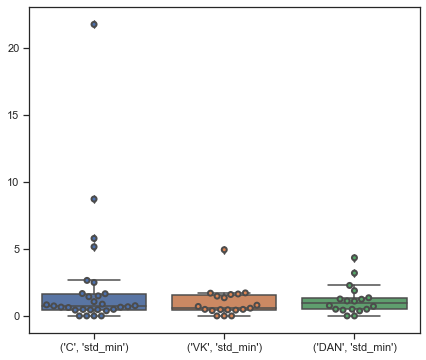

In [25]:
df = pd.concat ([tabulado_control5,tabulado_vk5,tabulado_dan5], axis=1, sort=False, keys=['C', 'VK','DAN'])
df
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=df)

sns.swarmplot(data=df, linewidth=2)

In [26]:
print(scipy.stats.ttest_ind(tabulado_control5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.ttest_ind(tabulado_control5['std_min'],tabulado_vk5['std_min']))
print(scipy.stats.ttest_ind(tabulado_vk5['std_min'],tabulado_dan5['std_min']))
# print(scipy.stats.shapiro(tabulado_dan5['std_min']))

Ttest_indResult(statistic=0.9308177804379796, pvalue=0.3569148035647336)
Ttest_indResult(statistic=1.1411590835009908, pvalue=0.25970991137893074)
Ttest_indResult(statistic=-0.5007131003403411, pvalue=0.6197074014789657)


In [27]:
DI_control = pd.read_csv(path + 'DI_control.csv')

In [28]:
min5 = []
for i in range(0,len(DI_control['file'])):
    cel = DI_control['file'][i]
    filtro_wc5 = tabulado_control5[(tabulado_control5['file'].str.contains(cel) == True)]
    min5.append (filtro_wc5['std_min'].values)
DI_control['min5'] = min5

In [31]:
DI_control.drop(4, inplace=True)
b = [j for i in DI_control['min5'].tolist() for j in i]
a = DI_control['DISCORDANCE 5 Hz']

In [32]:
from scipy.stats.stats import pearsonr 
print (pearsonr(DI_control['DISCORDANCE 5 Hz'],b))

ValueError: x and y must have the same length.

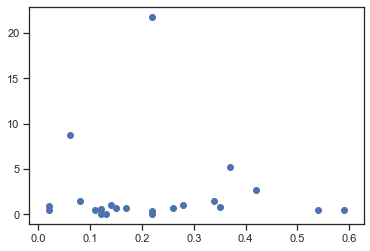

In [14]:
plt.scatter(a,b)

In [33]:
tabulado_control5

,file,std_min
0,010719ctrol1_analysis_result_ctrol1b0.json,5.787918
1,010719ctrol8_analysis_result_ctrol8a0.json,2.500000
2,010819c3_analysis_result_c3b001.json,5.165995
4,010819c1_analysis_result_c1b000.json,0.829156
5,010819c2_analysis_result_c2b000.json,21.777052
6,031019c4_analysis_result_c4e000.json,1.658312
7,031019c1_analysis_result_c1e000.json,2.653300
8,050320c1_analysis_result_c1d000.json,0.628539
9,050320c7_analysis_result_7d001.json,0.000000
10,050320c2_analysis_result_2d000.json,0.385695
